# Lab 01 : LeNet5 ChebGCNs - AXEL


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>
Advances in Neural Information Processing Systems, 3844-3852, 2016<br>
ArXiv preprint: [arXiv:1606.09375](https://arxiv.org/pdf/1606.09375.pdf) <br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import random
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import dgl
import networkx as nx
import matplotlib.pyplot as plt

#import collections
# MAC PROBLEM THAT MAKES THE NOTEBOOK Crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2

# MNIST

In [2]:
def check_mnist_dataset_exists(path_data='./'):
    flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt')
    flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt')
    flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt')
    flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt')
    if flag_train_data == False or flag_train_label == False or flag_test_data == False or flag_test_label == False:
        print('MNIST dataset missing - downloading...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
                                              download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
                                             download=True, transform=transforms.ToTensor())
        train_data = torch.Tensor(60000, 28, 28)
        train_label = torch.LongTensor(60000)
        
        for idx, example in enumerate(trainset):
            train_data[idx] = example[0].squeeze()
            train_label[idx] = example[1]

        torch.save(train_data, path_data + 'mnist/train_data.pt')
        torch.save(train_label, path_data + 'mnist/train_label.pt')
        test_data = torch.Tensor(10000, 28, 28)
        test_label = torch.LongTensor(10000)

        for idx, example in enumerate(testset):
            test_data[idx] = example[0].squeeze()
            test_label[idx] = example[1]
            
        torch.save(test_data, path_data + 'mnist/test_data.pt')
        torch.save(test_label, path_data + 'mnist/test_label.pt')
    return path_data


_ = check_mnist_dataset_exists()

In [3]:
nb_selected_train_data = 500
nb_selected_test_data = 100

train_data = torch.load('mnist/train_data.pt').reshape(60000, 784)
train_data = train_data[:nb_selected_train_data, :]
print(train_data.shape, type(train_data))

train_labels = torch.load('mnist/train_label.pt')
train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data = torch.load('mnist/test_data.pt').reshape(10000, 784)
test_data = test_data[:nb_selected_test_data, :]
print(test_data.shape)

test_labels = torch.load('mnist/test_label.pt')
test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

torch.Size([500, 784]) <class 'torch.Tensor'>
torch.Size([500])
torch.Size([100, 784])
torch.Size([100])


In [4]:
# Import the dataset from file
from Dataset import MNISTDataset

In [5]:
trainset = MNISTDataset(train_data,train_labels)
testset = MNISTDataset(test_data,test_labels)

In [6]:
def showGraph(graph, label):
    '''
    Function to visualise the signal of the handwritten digits over a lattice graph
    '''
    # Since the actual graph is undirected, we convert it
    nx_G = graph.to_networkx().to_undirected()

    # Kamada-Kawaii layout
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=graph.ndata['h'])
    plt.title('Class: {:d}'.format(label))
    plt.show()

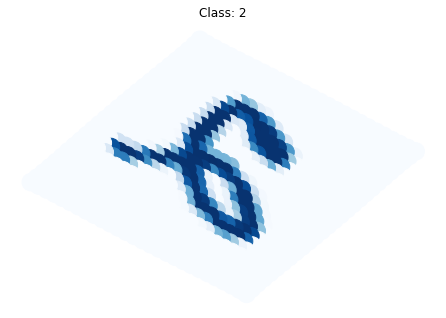

In [7]:
showGraph(*trainset[random.randrange(10)])

# Bis ChebNetDGL

In [8]:
def chebyshev(L, X, K):
    """Return T_k X where T_k are the Chebyshev polynomials of order up to K.
    Complexity is O(KMN)."""
    M, N = X.shape
    assert L.dtype == X.dtype

    # L = rescale_L(L, lmax)
    # Xt = T @ X: MxM @ MxN.
    # Xt_0 = T_0 X = I X = X.
    # Xt_1 = T_1 X = L X.
    # Xt_k = 2 L Xt_k-1 - Xt_k-2.
    
    Xt = np.empty((K, M, N), L.dtype)
    
    Xt[0, ...] = X
    if K > 1:
        Xt[1, ...] = L.dot(X)
        for k in range(2, K):
            Xt[k, ...] = 2 * L.dot(Xt[k-1, ...]) - Xt[k-2, ...]
    return Xt

In [9]:
## https://github.com/mdeff/cnn_graph/blob/c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53/lib/graph.py#L241

def rescale_L(L, lmax=2):
    """Rescale the Laplacian eigenvalues in [-1,1]."""
    M, M = L.shape
    I = scipy.sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax / 2
    L -= I
    return L

In [10]:
"""Torch Module for Chebyshev Spectral Graph Convolution layer"""
# pylint: disable= no-member, arguments-differ, invalid-name
import torch as th
from torch import nn
from torch.nn import init

from dgl import laplacian_lambda_max, broadcast_nodes, function as fn


class ChebConv(nn.Module):
    r"""Chebyshev Spectral Graph Convolution layer from paper `Convolutional
    Neural Networks on Graphs with Fast Localized Spectral Filtering
    <https://arxiv.org/pdf/1606.09375.pdf>`__.

    .. math::
        h_i^{l+1} &= \sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}

        Z^{0, l} &= H^{l}

        Z^{1, l} &= \hat{L} \cdot H^{l}

        Z^{k, l} &= 2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}

        \hat{L} &= 2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I

    Parameters
    ----------
    in_feats: int
        Number of input features.
    out_feats: int
        Number of output features.
    k : int
        Chebyshev filter size.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.
    """

    def __init__(self,
                 in_feats,
                 out_feats,
                 k,
                 bias=True):
        super(ChebConv, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.fc = nn.ModuleList([
            nn.Linear(in_feats, out_feats, bias=False) for _ in range(k)
        ])
        self._k = k
        if bias:
            self.bias = nn.Parameter(th.Tensor(out_feats))
        else:
            self.register_buffer('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        if self.bias is not None:
            init.zeros_(self.bias)
        for module in self.fc.modules():
            if isinstance(module, nn.Linear):
                init.xavier_normal_(module.weight, init.calculate_gain('relu'))
                if module.bias is not None:
                    init.zeros_(module.bias)

    def forward(self, graph, feat, lambda_max=None):
        r"""Compute ChebNet layer.

        Parameters
        ----------
        graph : DGLGraph or BatchedDGLGraph
            The graph.
        feat : torch.Tensor
            The input feature of shape :math:`(N, D_{in})` where :math:`D_{in}`
            is size of input feature, :math:`N` is the number of nodes.
        lambda_max : list or tensor or None, optional.
            A list(tensor) with length :math:`B`, stores the largest eigenvalue
            of the normalized laplacian of each individual graph in ``graph``,
            where :math:`B` is the batch size of the input graph. Default: None.
            If None, this method would compute the list by calling
            ``dgl.laplacian_lambda_max``.

        Returns
        -------
        torch.Tensor
            The output feature of shape :math:`(N, D_{out})` where :math:`D_{out}`
            is size of output feature.
        """
        with graph.local_scope():
            norm = th.pow(
                graph.in_degrees().float().clamp(min=1), -0.5).unsqueeze(-1).to(feat.device)
            if lambda_max is None:
                lambda_max = laplacian_lambda_max(graph)
            if isinstance(lambda_max, list):
                lambda_max = th.Tensor(lambda_max).to(feat.device)
            if lambda_max.dim() == 1:
                lambda_max = lambda_max.unsqueeze(-1)  # (B,) to (B, 1)
            # broadcast from (B, 1) to (N, 1)
            lambda_max = broadcast_nodes(graph, lambda_max)
            # T0(X)
            Tx_0 = feat
            rst = self.fc[0](Tx_0)
            '''
            print('\n First conv layer ------------- output 1 ------------- \n')
            print(rst, len(rst), 'Tx0 size', Tx_0.size())
            if(len(rst) == 10):
                print(
                    '\n ---- THIS CONV LAYER HAS THE RIGHT NUMBER OF OUTPUT FEATURES-----\n')
            '''
            # T1(X)
            if self._k > 1:
                graph.ndata.pop('h')
                #Actually I am the only one who has this problem?
                graph.ndata['h'] = Tx_0 * norm
                graph.update_all(fn.copy_u('h', 'm'), fn.sum(
                    'm', 'h'))  # STUDY THIS LINE LATER
                
                #print(graph.ndata, graph.ndata['h'].size(),'norm',norm.size() )
                
                
                h = graph.ndata.pop('h') * norm
                
                # Λ = 2 * (I - D ^ -1/2 A D ^ -1/2) / lambda_max - I
                #   = - 2(D ^ -1/2 A D ^ -1/2) / lambda_max + (2 / lambda_max - 1) I
                Tx_1 = -2. * h / lambda_max + Tx_0 * (2. / lambda_max - 1) # ERROR IS HERE MOUAHAHA

                rst = rst + self.fc[1](Tx_0)
                '''
                print('\n DEBUG ------------- output 2 ----------- \n')
                print('CHECKING OUT THAT MATHAFACK FUNCTION')
                print('h',h,'size:',h.size())
                #print('size of tx0',Tx_0.size(),'sum:', Tx_0 * (2. / lambda_max - 1))
                print('\nTx1', Tx_1, 'Len:', len(Tx_1), 'type:', Tx_1.size())
                print('\n net:', self.fc[1], '\n output (TEST):', self.fc[1](
                    Tx_1), 'length', len(self.fc[1](Tx_1)))
                print('\n Final output', rst, 'length:', len(rst))
                if(len(rst) == 10):
                    print(
                        '\n ---- THIS CONV LAYER HAS THE RIGHT NUMBER OF OUTPUT FEATURES-----\n')
                '''
                
            # Ti(x), i = 2...k
            for i in range(2, self._k):
                assert graph.ndata == {}
                #graph.ndata.pop('h')
                graph.ndata['h'] = Tx_1 * norm
                graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
                h = graph.ndata.pop('h') * norm
                # Tx_k = 2 * Λ * Tx_(k-1) - Tx_(k-2)
                #      = - 4(D ^ -1/2 A D ^ -1/2) / lambda_max Tx_(k-1) +
                #        (4 / lambda_max - 2) Tx_(k-1) -
                #        Tx_(k-2)
                Tx_2 = -4. * h / lambda_max + Tx_1 *(4. / lambda_max - 2) - Tx_0
                rst = rst + self.fc[i](Tx_2)
                '''
                print('\n DEBUG ------------- output 3 ----------- \n')
                print('h',h,'size:',h.size())
                print('\nTx2', Tx_2, 'Len:', len(Tx_2), 'type:', Tx_2.size())
                print('\n net:', self.fc[i], '\n output (TEST):', self.fc[i](
                    Tx_2), 'length', len(self.fc[i](Tx_2)))
                print('\n Final output', rst, 'length:', len(rst))
                if(len(rst) == 10):
                    print(
                        '\n ---- THIS CONV LAYER HAS THE RIGHT NUMBER OF OUTPUT FEATURES-----\n')
                '''
                Tx_1, Tx_0 = Tx_2, Tx_1
            # add bias
            
            if self.bias is not None:
                rst = rst + self.bias

            return rst

# Model

In [11]:
#net = GCN(784, trainset.num_classes)
net = ChebConv(784, trainset.num_classes, 2)
print(net)

ChebConv(
  (fc): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=False)
    (1): Linear(in_features=784, out_features=10, bias=False)
  )
)


# Training

In [12]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [13]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=1,
                         shuffle=True, collate_fn=collate)

# Create model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [14]:
epoch_losses = []
net.train()
for epoch in range(20):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = net(bg,bg.ndata['h']).view(1,-1)
        
        #print("Prediction:", prediction,'len:',prediction.size())
        lossvect=torch.zeros(1, dtype=torch.long)
        lossvect[0] = label
        #print("lossv:", lossvect,'len:',lossvect.size())
        loss = loss_func(prediction, lossvect)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 0.9767
Epoch 1, loss 0.3627
Epoch 2, loss 0.2302
Epoch 3, loss 0.1611
Epoch 4, loss 0.1102
Epoch 5, loss 0.0831
Epoch 6, loss 0.0574
Epoch 7, loss 0.0437
Epoch 8, loss 0.0332
Epoch 9, loss 0.0255
Epoch 10, loss 0.0211
Epoch 11, loss 0.0165
Epoch 12, loss 0.0134
Epoch 13, loss 0.0102
Epoch 14, loss 0.0088
Epoch 15, loss 0.0071
Epoch 16, loss 0.0057
Epoch 17, loss 0.0043
Epoch 18, loss 0.0035
Epoch 19, loss 0.0029


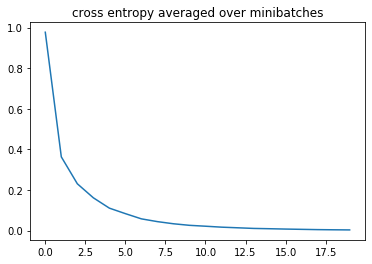

In [15]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [16]:
net.eval()
data_loader_test = DataLoader(testset, batch_size=1,
                              shuffle=False, collate_fn=collate)
loss = 0
preds = []
test = 0
for iter, (bg, label) in enumerate(data_loader):
    prediction = net(bg, bg.ndata['h'])
    preds.append(prediction)
    test = prediction
    loss = loss_func(prediction.view(1,-1), label)
    
    loss += loss
print('Total Loss {:.4f}'.format(loss*100))

Total Loss 0.0086


In [17]:
from sklearn.metrics import classification_report



In [19]:
prediction

tensor([  0.1006, -25.5242, -14.9417,  -5.1505, -13.4526,  -7.2645, -13.7934,
         10.1673, -10.5867,  -5.1622], grad_fn=<AddBackward0>)

In [23]:
probs = torch.softmax(prediction.view(-1,1)).detach().numpy()
pred_y = np.argmax(probs,1)

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, name dim, torch.dtype dtype)
 * (Tensor input, int dim, torch.dtype dtype)


In [ ]:
net.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
#test_bg = dgl.batch(test_X)


test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(net(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)


print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

# GCN

# Other Shit

In [ ]:
# learning parameters
learning_rate = 0.05
dropout_value = 0.5
l2_regularization = 5e-4 
batch_size = 100
num_epochs = 30
train_size = train_data.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs=',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)


# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 


# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:].T, train_labels[batch_idx].T
        train_x = np.reshape(train_x,[28,28,batch_size])[:,:,:,None]
        train_x = np.transpose(train_x,[2,3,1,0]) # reshape from pytorch array to tensorflow array
        train_x = Variable( torch.FloatTensor(train_x).type(dtypeFloat) , requires_grad=False) 
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong)
        train_y = Variable( train_y , requires_grad=False) 
            
        # Forward 
        y = net.forward(train_x, dropout_value)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.detach().item()
        
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        
        # backward
        loss.backward()
        
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        
        # print        
        if not running_total%100: # print every x mini-batches
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
       
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 

    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    running_accuray_test = 0
    running_total_test = 0
    indices_test = collections.deque()
    indices_test.extend(range(test_data.shape[0]))
    t_start_test = time.time()
    while len(indices_test) >= batch_size:
        batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
        test_x, test_y = test_data[batch_idx_test,:].T, test_labels[batch_idx_test].T
        test_x = np.reshape(test_x,[28,28,batch_size])[:,:,:,None]
        test_x = np.transpose(test_x,[2,3,1,0]) # reshape from pytorch array to tensorflow array
        test_x = Variable( torch.FloatTensor(test_x).type(dtypeFloat) , requires_grad=False) 
        y = net.forward(test_x, 0.0) 
        test_y = test_y.astype(np.int64)
        test_y = torch.LongTensor(test_y).type(dtypeLong)
        test_y = Variable( test_y , requires_grad=False) 
        acc_test = net.evaluation(y,test_y.data)
        running_accuray_test += acc_test
        running_total_test += 1
    t_stop_test = time.time() - t_start_test
    print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))

In [39]:
def graph_conv_cheby(self, x, cl, L, lmax, Fout, K):

        # parameters
        # B = batch size
        # V = nb vertices
        # Fin = nb input features
        # Fout = nb output features
        # K = Chebyshev order & support size
        B, V, Fin = x.size()
        B, V, Fin = int(B), int(V), int(Fin)

        # rescale Laplacian
        lmax = lmax_L(L)
        L = rescale_L(L, lmax)

        # convert scipy sparse matric L to pytorch
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col)).T
        indices = indices.astype(np.int64)
        indices = torch.from_numpy(indices)
        indices = indices.type(torch.LongTensor)

        L_data = L.data.astype(np.float32)
        L_data = torch.from_numpy(L_data)
        L_data = L_data.type(torch.FloatTensor)

        L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
        L = Variable(L, requires_grad=False)
        if torch.cuda.is_available():
            L = L.cuda()

        # transform to Chebyshev basis
        x0 = x.permute(1, 2, 0).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])            # V x Fin*B
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B

        def concat(x, x_):
            x_ = x_.unsqueeze(0)            # 1 x V x Fin*B
            return torch.cat((x, x_), 0)    # K x V x Fin*B

        if K > 1:
            x1 = my_sparse_mm.apply(L, x0)              # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)), 0)  # 2 x V x Fin*B
        for k in range(2, K):
            x2 = 2 * my_sparse_mm.apply(L, x1) - x0
            x = torch.cat((x, x2.unsqueeze(0)), 0)  # M x Fin*B
            x0, x1 = x1, x2

        x = x.view([K, V, Fin, B])           # K x V x Fin x B
        x = x.permute(3, 1, 2, 0).contiguous()  # B x V x Fin x K
        x = x.view([B*V, Fin*K])             # B*V x Fin*K

        # Compose linearly Fin features to get Fout features
        x = cl(x)                            # B*V x Fout
        x = x.view([B, V, Fout])             # B x V x Fout

        return x


Chebyshev Spectral Graph Convolution layer from paper Convolutional
    Neural Networks on Graphs with Fast Localized Spectral Filtering
    <https://arxiv.org/pdf/1606.09375.pdf>

$h_i^{l+1}$ &= $\sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}$

$Z^{0, l}$ &= $H^{l}$

$Z^{1, l}$ &=$ \hat{L} \cdot H^{l}$

$Z^{k, l}$ &= $2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}$

$\hat{L}$ &= $2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I$

    Parameters
    ----------
    in_feats: int
        Number of input features.
    out_feats: int
        Number of output features.
    k : int
        Chebyshev filter size.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.